## Texture vs Shape: introduction
(homework #2 for DNN 2024/25)

<div style="max-width: 60em">

In this homework, we will look at a modern residual convolutional net. While they perform very well on image classification tasks, some problems they commonly have are that:<br>
* they rely too much on small-scale features (textures) rather than large-scale ones (shape). This often generalizes poorly to unseen datasets and is less human-aligned (e.g. explanations of why a model chose this class may be less interpretable).
* they are very susceptible to adversarial images, i.e. inputs maliciously altered in a way that is imperceptible to humans and shouldn't change the classification, but completely fool the model, making it output high probabilities for unrelated classes.

While the two problems are somewhat related, we focus on the first one.
You are given a pre-trained model and datasets, as well as the code for standard evaluation and training loops, and for generating adversarial examples.
Your tasks (fully detailed in later cells) will be as follows:

0. Adapt a pretrained model to the smaller datasets by changing the classification layer.
1. Implement transformations (blur, pixelize, noise) that can help us elucidate and perhaps remedy the texture-bias problem.
2. Compare how the model handles them and how much they help as augmentations used in fine-tuning.
3. Read a paper about AdvProp: a relatively simple method for training models with less texture bias, using adversarial examples; implement and evaluate it.
4. Implement and evaluate SparseTopK: another, even simpler method proposed for the same problem: it just zeroes all but the top 20% activations in some layers.

Submission requirements:
* Please do not modify anything outside of the `### BEGIN SOLUTION ... ### END SOLUTION` blocks (if you feel it might be useful somewhere, ask on slack).
* Please make sure to submit your solution as a notebook with saved cell outputs.
* Don't use `tqdm.notebook` or `tqdm.auto`, just plain `tqdm`.
* It should be possible to execute the notebook from top to bottom when loaded in Colab with a GPU, in a reasonable amount of time.
* Plots should either be images embedded in cell outputs (in a way that shows correctly when loading the notebook from file, without executing it), or attached together with the exported .ipynb notebook in a .zip file  (screenshots are admissible, but prefer exporting with e.g. `plt.savefig()`).

</div>

## Imports

In [ ]:
import json
import multiprocessing
from collections.abc import Callable, Iterable, Sequence
from copy import deepcopy
from functools import partial
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import torch
import torch.nn
import torch.nn.functional as F
import torchvision.models
import torch.optim.lr_scheduler
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

### BEGIN SOLUTION
# Feel free to add more imports and global settings here, though none are necessary.
### END SOLUTION

%matplotlib inline

multiprocessing.set_start_method("spawn", force=True)  # Needed when using CUDA.
torch.set_num_threads(8)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    torch.cuda.set_device(2)

_ = torch.manual_seed(42)

## Datasets

In [ ]:
%%bash
# 219 MiB
if [ ! -d datasets ]; then
    gdown https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg \
        && tar -xf datasets.tar.gz \
        && rm datasets.tar.gz
fi

Downloading...
From (original): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg
From (redirected): https://drive.google.com/uc?id=1Xpl0QQaAuTULtGvpdixTISDkUNMhzBMg&confirm=t&uuid=784d9f21-2bcc-4734-ab65-b2584fc75ed9
To: /content/datasets.tar.gz
100%|██████████| 229M/229M [00:00<00:00, 269MB/s]


##### MiniImageNet
MiniImageNet is a downscaled subset of ISVLRC ImageNet-1k<sup>[1]</sup> with only 10 classes (RGB, irregular sizes up to 256x256).
Train/val is a uniformly random split, the parts have 2000/100 images per class, respectively.

We will use the *train* part for fine-tuning and *val* for validation and various evaluation.

[1] https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview

['bear', 'bicycle', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'elephant', 'truck']


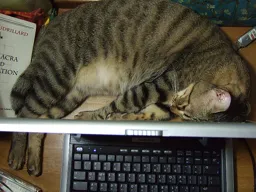

5 cat


In [ ]:
MINI_IMAGENET_PATH = Path("datasets/miniImageNet")
SELECTED_CLASSES = ImageFolder(MINI_IMAGENET_PATH / "train").classes
assert SELECTED_CLASSES == ImageFolder(MINI_IMAGENET_PATH / "val").classes


def example() -> None:  # Note: we scope examples to avoid polluting the global namespace.
    print(SELECTED_CLASSES)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val")
    img, label = dataset[505]
    display(img)
    print(label, dataset.classes[label])


example()

##### eval_transform, display_image_tensor()

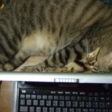

img.shape=torch.Size([3, 112, 112]), img.dtype=torch.float32, min..max=-2.015..2.64
label=5 (cat)


In [ ]:
def get_eval_transform() -> v2.Compose:
    """
    The default transform used on all ImageNet images before passing to a model.

    (Typically papers end up with 224x224 images, we make them smaller for speed.)
    """
    return v2.Compose(
        [
            v2.PILToTensor(),
            v2.Resize(size=128, antialias=True),
            v2.CenterCrop(size=(112, 112)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
        ]
    )


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize an image tensor of shape (*B, C, H, W) from 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return (x - mean) / std


def unnormalize(x: torch.Tensor) -> torch.Tensor:
    """Revert an image tensor of shape (*B, C, H, W) to 0..1 values."""
    std = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    mean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device, dtype=x.dtype).reshape(3, 1, 1)
    return x * std + mean


def display_image_tensor(x: torch.Tensor) -> None:
    """Display a normalized image tensor of shape (C, H, W) as a PIL Image."""
    pil_image: PIL.Image.Image = v2.ToPILImage()(unnormalize(x))
    display(pil_image)


def ceildiv(a: int, b: int) -> int:
    """Return ceil(a /b)."""
    return -(-a // b)


def example() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[505]
    display_image_tensor(img)
    print(f"{img.shape=}, {img.dtype=}, min..max={img.min().item():.4g}..{img.max().item():.4g}")
    print(f"{label=} ({dataset.classes[label]})")


example()

##### alt_test_dataset
This is a dataset with the same classes and some of the same images, but restylized or otherwise altered to mislead models reliant on textures.
We will use this dataset to test if a training method results in a model that is less reliant on textures.
Note that some alterations are pretty heavy, so the images look very different and it is difficult to achieve more than ~40-50% accuracy.

RGB, 224x224, 280 images per class.

(The dataset was created from https://github.com/bethgelab/model-vs-human/releases/tag/v0.1)

cue-conflict 800, edge 100, low-pass 800, silhouette 100, sketch 500, stylized 500, total 2800


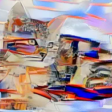

In [ ]:
ALT_TEST_DATASET_PATHS = sorted(Path("datasets/testSets").iterdir())
alt_test_dataset = ConcatDataset([ImageFolder(p, transform=get_eval_transform()) for p in ALT_TEST_DATASET_PATHS])


def example() -> None:
    for p in ALT_TEST_DATASET_PATHS:
        dataset = ImageFolder(p, transform=get_eval_transform())
        assert dataset.classes == SELECTED_CLASSES
        print(p.name, len(dataset), end=", ")
        # display_image_tensor(dataset[int(len(dataset) * 0.53)][0])
    print("total", len(alt_test_dataset))

    img, _label = alt_test_dataset[445]
    display_image_tensor(img)


example()

## Evaluate() and get_dataloader()

Here's an implementation of an evaluation loop, to be used in this notebook.

In [ ]:
def get_dataloader(
    dataset: Dataset,
    shuffle: bool = False,
    batch_size: int = 256,
    num_workers: int = 2,
    pin_memory: bool = True,
    prefetch_factor: int = 2,
    persistent_workers: bool = True,
    timeout: float = 30.0,
    **kwargs: Any,
) -> DataLoader:
    """DataLoader constructor with different defaults."""
    if num_workers == 0:
        pin_memory = False
        persistent_workers = False
        prefetch_factor = None
        timeout = 0.0

    return DataLoader(
        dataset,
        shuffle=shuffle,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        prefetch_factor=prefetch_factor,
        persistent_workers=persistent_workers,
        timeout=timeout,
        **kwargs,
    )

In [ ]:
def evaluate(
    model: torch.nn.Module,
    dataloader: Dataset | DataLoader,
    description: str = "eval",
    device: str = DEVICE,
    quiet: bool = False,
    use_workers: bool = True,
) -> float:
    """Evaluate a model on a dataset or dataloader, returning the accuracy (0..1)."""
    model = model.to(device).eval()
    if not isinstance(dataloader, DataLoader):  # Create from dataset.
        if use_workers:
            dataloader = get_dataloader(dataloader, persistent_workers=False)
        else:
            dataloader = get_dataloader(dataloader, num_workers=0)

    accuracy, n_done, n_correct = 0, 0, 0

    progress_bar = tqdm(dataloader, desc=description, disable=quiet, delay=0.5)
    with torch.no_grad(), progress_bar:
        for image_batch, label_batch in progress_bar:
            logits_batch = model(image_batch.to(device))
            predictions = logits_batch.argmax(dim=1)

            n_done += len(label_batch)
            n_correct += (predictions == label_batch.to(device)).sum().item()
            accuracy = n_correct / n_done if n_done else 0
            progress_bar.set_postfix({"accuracy": f"{accuracy * 100:.1f} %"})

    return accuracy

## Task 0: Model, remapping the classification layer

We will use a ready-made model pretrained on ImageNet-1k.<br>
Since they all output logits for 1000 classes (`IMAGENET_CATEGORIES`),<br>
we need to alter the classification layer to output logits for the 10 MiniImageNet classes instead (`SELECTED_CLASSES`).<br>
Note that several ImageNet-1k classes can map to the same MiniImageNet class.<br>

Your task is to complete the implementation of `remap_output_layer()` below,<br>
so that the model works without any fine-tuning/training of the last layer.<br>
In `example_remapping()` below (which evaluates the model on the val dataset),<br>
you should achieve at least 70% accuracy and finish in under 35 seconds on Colab CPU (~15s on GPU).<br>

In [ ]:
SELECTED_MODEL = (torchvision.models.efficientnet_b0, torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)
# 5.3M params, 78% acc@1 on original ImageNet-1k

# Other models we considered, but cut for time:
# * (torchvision.models.mobilenet_v3_small, torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
#     2.5M params, 68% acc@1
# * (torchvision.models.resnet18, torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
#     11.7M params, 70% acc@1 on original ImageNet-1k
# * (torchvision.models.efficientnet_v2_s, torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
#     21.5M params, 84% acc@1

IMAGENET_CATEGORIES = SELECTED_MODEL[1].meta["categories"]
assert IMAGENET_CATEGORIES == torchvision.models.ResNet18_Weights.IMAGENET1K_V1.meta["categories"]
print(len(IMAGENET_CATEGORIES), ", ".join(IMAGENET_CATEGORIES[:7] + ["..."]))

1000 tench, goldfish, great white shark, tiger shark, hammerhead, electric ray, stingray, ...


In [ ]:
# Some technical details, feel free to ignore.


def _load_imagenet_id_to_class_id_map(classes: Sequence[str] = SELECTED_CLASSES) -> dict[int, int]:
    """
    Return a map from imagenet ids 0..999 to selected class ids: 0..len(classes)-1.

    Classes should be a subset of the following 16 class names:
        airplane,bear,bicycle,bird,boat,bottle,car,cat,chair,clock,dog,elephant,keyboard,knife,oven,truck
    """
    imagenet_id_to_name = {i: name for i, name in enumerate(IMAGENET_CATEGORIES)}
    class_to_idx = {name: i for i, name in enumerate(classes)}
    with open("datasets/imagenet_name_to_synset_id.json") as f:
        name_to_synset = json.load(f)
    with open("datasets/synset_id_to_class.json") as f:
        synset_to_class = json.load(f)
    # Not all synsets defined in synset_id_to_class.json are present in ImageNet-1k
    # (they also don't appear in our dataset 10-class-ImageNet).
    imagenet_name_to_class_name = {
        name: synset_to_class[synset] for name, synset in name_to_synset.items() if synset in synset_to_class
    }

    result = dict[int, int]()
    for imagenet_id, imagenet_name in imagenet_id_to_name.items():
        # Not all imagenet names are present in 10-class-ImageNet, obviously.
        if imagenet_name in imagenet_name_to_class_name:
            class_name = imagenet_name_to_class_name[imagenet_name]
            # Not all class names defined for 16-class-ImageNet are present in our dataset 10-class-ImageNet.
            if class_name in class_to_idx:
                result[imagenet_id] = class_to_idx[class_name]

    for k, v in result.items():
        assert 0 <= k < len(IMAGENET_CATEGORIES) and 0 <= v < len(classes)

    return result


def _reset_model_weights(model: torch.nn.Module) -> None:
    """Reinitialize the model weights randomly. We probably won't use it."""
    # Some models define reset_parameters(), but unfortunately not all.
    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, mode="fan_out")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.BatchNorm2d | torch.nn.GroupNorm):
            torch.nn.init.ones_(m.weight)
            torch.nn.init.zeros_(m.bias)
        elif isinstance(m, torch.nn.Linear):
            init_range = 1.0 / np.sqrt(m.out_features)
            torch.nn.init.uniform_(m.weight, -init_range, init_range)  # EfficientNet v1
            # torch.nn.init.normal_(m.weight, 0, 0.01)  # MobileNet v3
            torch.nn.init.zeros_(m.bias)

In [ ]:
def remap_output_layer(layer: torch.nn.Linear, id_map: dict[int, int]) -> torch.nn.Module:
    """Return a new final classification logit layer where the i-th class becomes id_map[i] instead."""
    assert layer.out_features == len(IMAGENET_CATEGORIES)

    ### BEGIN SOLUTION

    new_out_features = len(set(id_map.values()))

    new_layer = torch.nn.Linear(layer.in_features, new_out_features)

    with torch.no_grad():
        old_weights = layer.weight
        new_weights = torch.zeros(new_out_features, layer.in_features)

        old_bias = layer.bias
        new_bias = torch.zeros(new_out_features)

        for old_class, new_class in id_map.items():
            new_weights[new_class] += old_weights[old_class]
            new_bias[new_class] += old_bias[old_class]

        new_weights /= len(id_map)
        new_bias /= len(id_map)
        new_layer.weight.copy_(new_weights)
        new_layer.bias.copy_(new_bias)

    return new_layer

    ### END SOLUTION

In [ ]:
def get_model(
    eval: bool = False, reset: bool = False, selected_classes: Sequence[str] = SELECTED_CLASSES
) -> torch.nn.Module:
    model_fn, model_weights = SELECTED_MODEL
    model = model_fn(weights=model_weights)

    # Find and replace the last Linear layer.
    id_map = _load_imagenet_id_to_class_id_map(selected_classes)
    last_linear_layer = None
    for parent_module in model.modules():
        for name, layer in parent_module.named_children():
            if isinstance(layer, torch.nn.Linear):
                last_linear_layer = (parent_module, name, layer)
    assert last_linear_layer is not None
    parent_module, name, layer = last_linear_layer

    setattr(parent_module, name, remap_output_layer(layer, id_map))

    if reset:
        _reset_model_weights(model)

    return model.eval() if eval else model.train()


get_model(eval=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 170MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
def example_remapping() -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    model = get_model(eval=True)
    evaluate(model, dataset)


example_remapping()

eval: 100%|██████████| 4/4 [00:11<00:00,  2.98s/it, accuracy=87.2 %]


## Training

Here's an implementation of a training loop that we will use for this notebook.
You should not need to alter hyperparameters, use the defaults of `Trainer.__init__()`.

In [ ]:
BATCH_NORM_TYPES = (
    torch.nn.BatchNorm1d
    | torch.nn.BatchNorm2d
    | torch.nn.BatchNorm3d
    | torch.nn.SyncBatchNorm
    | torch.nn.LazyBatchNorm1d
    | torch.nn.LazyBatchNorm2d
    | torch.nn.LazyBatchNorm3d
)


class Trainer:
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = DEVICE,
        extra_augmentation: v2.Transform | None = None,
        use_workers: bool = True,
    ):
        self.lr = lr
        self.weight_decay = weight_decay
        self.n_epochs = n_epochs
        self.device = device
        self.batch_norm_momentum = batch_norm_momentum
        if extra_augmentation is not None:
            self.extra_augmentation = v2.RandomApply([extra_augmentation], p=0.5)
        else:
            self.extra_augmentation = v2.GaussianBlur(kernel_size=9, sigma=(0.1, 9.0))
        self.num_workers = 2 if use_workers else 0

    def get_train_transform(self) -> v2.Transform:
        return v2.Compose(
            [
                v2.PILToTensor(),
                v2.RandomResizedCrop(size=(112, 112), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.AutoAugment(interpolation=v2.InterpolationMode.BILINEAR),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                self.extra_augmentation,
                v2.RandomErasing(p=0.2),
                v2.ToPureTensor(),
            ]
        )

    def get_train_dataloader(self) -> DataLoader:
        transform = self.get_train_transform()
        train_dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
        return get_dataloader(train_dataset, shuffle=True, num_workers=self.num_workers)

    def get_eval_dataloaders(self) -> dict[str, DataLoader]:
        transform = get_eval_transform()
        val_dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
        return {
            "val": get_dataloader(val_dataset, num_workers=self.num_workers),
            "alt": get_dataloader(alt_test_dataset, num_workers=self.num_workers),
        }

    def get_optimizer_and_scheduler(
        self, parameters: Iterable[torch.nn.Parameter]
    ) -> tuple[torch.optim.Optimizer, torch.optim.lr_scheduler.LRScheduler]:
        optimizer = torch.optim.AdamW(parameters, lr=self.lr, weight_decay=self.weight_decay, fused=True)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
        return optimizer, lr_scheduler

    def do_evaluations(self, model: torch.nn.Module, eval_dataloaders: dict[str, DataLoader]) -> dict[str, float]:
        result = dict[str, float]()
        for k, d in eval_dataloaders.items():
            result[k] = evaluate(model, d, description=k, quiet=True)
            print(f"{k}={result[k] * 100:.1f} %", end="\t", flush=True)
        print()
        return result

    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
        model = model.to(self.device)

        if self.batch_norm_momentum is not None:
            # Default torch.nn.BatchNorm2D.momentum is 0.1, but it's often too high.
            for m in model.modules():
                if isinstance(m, BATCH_NORM_TYPES):
                    m.momentum = self.batch_norm_momentum

        train_dataloader = self.get_train_dataloader()
        eval_dataloaders = self.get_eval_dataloaders()
        optimizer, lr_scheduler = self.get_optimizer_and_scheduler(model.parameters())

        results = {k: [] for k in eval_dataloaders.keys()}
        for k, v in self.do_evaluations(model, eval_dataloaders).items():
            results[k].append(v)

        for epoch in range(1, self.n_epochs + 1):
            self.train_epoch(model, train_dataloader, optimizer, epoch)
            lr_scheduler.step()

            for k, v in self.do_evaluations(model, eval_dataloaders).items():
                results[k].append(v)

        return results

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()
        n_correct = 0
        n_total = 0
        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

            optimizer.zero_grad()
            logits_batch = model(image_batch)
            loss = torch.nn.CrossEntropyLoss()(logits_batch, label_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                n_correct += (logits_batch.argmax(dim=1) == label_batch).sum().item()
                n_total += len(label_batch)
            accuracy = n_correct / n_total
            progress_bar.set_postfix({"train-acc": f"{accuracy * 100:.1f} %", "lr": optimizer.param_groups[0]["lr"]})


## Task 1: Implementing augmentations

In this task, you are asked to implement a few transformations that can help in assessing whether a model relies more on texture or shape information.

Consider using functions from [torch.nn.functional](https://pytorch.org/docs/stable/nn.functional.html), in particular [vision](https://pytorch.org/docs/stable/nn.functional.html#vision-functions), [convolution](https://pytorch.org/docs/stable/nn.functional.html#convolution-functions), and [pooling](https://pytorch.org/docs/stable/nn.functional.html#pooling-functions) functions (or corresponding modules in `torch.nn`).

In all cases, the transform should take a normalized image of shape `(*B, C, H, W)` (where `*B` represents any number of extra dimensions, possibly none) and dtype `float32`, and it should output the same.
Do not change the tensor's device (it will be CPU).

Use the following functions to check and benchmark your transforms. Each benchmark should take <20s (on Colab CPU, the GPU is not used here even if available).

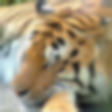

In [ ]:
def example_transformed(transform: Callable[[torch.Tensor], torch.Tensor], image_id: int = 510, seed: int = 42) -> None:
    torch.manual_seed(seed)
    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[image_id]
    with torch.no_grad():
        img = transform(img)
    display_image_tensor(img)


def benchmark_transform(transform: v2.Transform) -> None:
    dataset = ImageFolder(MINI_IMAGENET_PATH / "train", transform=transform)
    dataset = Subset(dataset, range(2500))
    dataloader = get_dataloader(dataset, batch_size=256, num_workers=0)
    for _image_batch, _label_batch in tqdm(dataloader):
        pass


example_transformed(v2.GaussianBlur(kernel_size=25, sigma=2.0), 513)

#### 1a: Blur
Implement a transformation that blurs the image (any method that makes the image visually smoother in all directions is fine).<br>
The transform should be parameterized by strength (from roughly 1 meaning no/minimal blurring to 100 meaning the image becomes unrecognizable to humans).<br>
For task 1a specifically, do not use any library beyond `torch.*` and python built-ins (in particular, do not use `torchvision`'s `GaussianBlur`).<br>

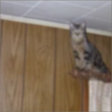

In [ ]:
def blur(x: torch.Tensor, strength: int = 10) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    *B, C, H, W = x.shape


    ### BEGIN SOLUTION

    kernel_size = max(3, (strength // 20) * 2 + 3)

    sigma = strength / 10.0

    x_coords = torch.arange(kernel_size).float() - kernel_size // 2
    y_coords = torch.arange(kernel_size).float() - kernel_size // 2

    x_grid, y_grid = torch.meshgrid(x_coords, y_coords, indexing='ij')

    kernel = torch.exp(-(x_grid ** 2 + y_grid ** 2) / (2 * sigma ** 2))
    kernel /= kernel.sum()
    kernel = kernel.expand(C, 1, kernel_size, kernel_size)

    padding = (kernel_size - 1) // 2

    x = F.conv2d(x, kernel, padding=padding, groups=C)

    x = x.view(*B, C, H, W)

    ### END SOLUTION
    return x


example_transformed(blur, 507)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(blur)]))

100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


#### 1b: Pixelize
Implement a transformation that averages blocks of `block_height x block_width` pixels, as in the example below.

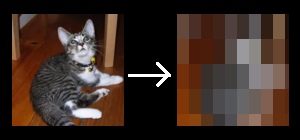

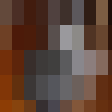

In [ ]:
def pixelize(x: torch.Tensor, block_height: int = 8, block_width: int = 8) -> torch.Tensor:
    assert 1 <= block_height and 1 <= block_width, f"Expected ≥1, got {block_height=}, {block_width=}."

    ### BEGIN SOLUTION

    *B, C, H, W = x.shape

    pad_h = (block_height - H % block_height) % block_height
    pad_w = (block_width - W % block_width) % block_width

    x = F.pad(x, (0, pad_w, 0, pad_h), mode='replicate')
    x = F.avg_pool2d(x, kernel_size=(block_height, block_width))

    x = x.repeat_interleave(block_height, dim=-2).repeat_interleave(block_width, dim=-1)

    x = x[..., :H, :W]

    ### END SOLUTION
    return x


example_transformed(lambda x: pixelize(x, 25, 12), 510)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(pixelize)]))

100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


#### 1c: Noise

Implement a transformation that adds noise (same on each channel, up to normalization constants) to an image.<br>
Any kind of noise like that is fine, but it should be parameterized by noise strength (from 1 unnoticeable to 100 unrecognizable) and grain size (roughly in pixels), as in the four examples below.<br>

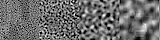

In [ ]:
def noise(x: torch.Tensor, strength: int = 25, grain_size: int = 5) -> torch.Tensor:
    assert 1 <= strength <= 100, f"Expected 1 ≤ strength ≤ 100, got {strength}."
    assert 1 <= grain_size <= 100, f"Expected 1 ≤ grain_size ≤ 100, got {grain_size}."

    ### BEGIN SOLUTION

    *B, C, H, W = x.shape

    x = x.view(-1, C, H, W)
    x = unnormalize(x)

    small_h = H // grain_size
    small_w = W // grain_size

    noise_pattern = torch.randn(1, 1, small_h, small_w)
    noise_pattern = F.interpolate(noise_pattern, size=(H, W), mode='bilinear', align_corners=False)
    noise_pattern = noise_pattern * (strength / 200.0)

    x_noisy = x + noise_pattern
    x_noisy = torch.clamp(x_noisy, 0.0, 1.0)
    x_noisy = normalize(x_noisy)

    x = x_noisy.view(*B, C, H, W)

    ### END SOLUTION

    return x

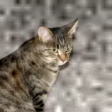

In [ ]:
example_transformed(noise, 506)

In [ ]:
benchmark_transform(v2.Compose([get_eval_transform(), v2.Lambda(noise)]))

100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


## Task 2: Comparing augmentations

Focus on the readability of the presented results.

Note: to use transforms defined in a notebook, you will have to call `evaluate()` with `use_workers=False`<br>
(this is because functions are pickled by reference, and those defined in a notebook cannot be imported by workers spawned by a dataloader;<br>
other workarounds include writing a Python module e.g. with `%%writefile file.py`, or using the `cloudpickle` package, but we prefer to keep it simple here).

#### Side note: lambdas in for loops

Since in this task it may be useful to use lots of lambdas (to change default parameters in your transformations),<br>
we would like to warn about one potential pitfall here.<br>

One 'gotcha' in Python is that 'for' variables (and similar blocks) are not scoped to the loop body,<br>
they continue with the value from the last iteration.

In [ ]:
def example() -> None:
    for i in range(3):
        for j in range(3):
            pass
        print(j)


example()

2
2
2


This is sometimes useful and mostly benign, but we may overlook using the wrong variable.

Another gotcha is that closures in Python (lambdas or def-s using variables from external scopes)<br>
are *late-binding*, meaning variables are captured by reference,<br>
so especially together with the previous gotcha, we get a probably-not-so-intuitive result:

In [ ]:
def example() -> None:
    funcs = [(lambda x: x + a) for a in range(3)]
    for f in funcs:
        print(f(0))


example()

2
2
2


Use `lambda x, a=a: f(x,a)` or `functools.partial(f, a=a)` to capture by value instead.

(A linter like [ruff](https://docs.astral.sh/ruff/) will warn you about both gotchas, by detecting e.g. [unused loop variables](https://docs.astral.sh/ruff/rules/unused-loop-control-variable/) and [loop variables used in closures](https://docs.astral.sh/ruff/rules/function-uses-loop-variable/), unfortunately there is no easy way to use them in Colab).

#### 2a: On vanilla model

Compare how `get_model()` performs on inputs from the `val` dataset, when transformed with your transformations (one at a time) or with `v2.GaussianBlur`, using different transform parameters.
(Use each transformation after `get_eval_transform()`, as in the benchmarks above.)

Plot the results. The total time taken by computations for this subtask must not exceed 10 minutes (on Colab GPU)<br>
(use fewer than 100 calls to evaluate(); if running on CPU, expect less than 40 minutes).<br>
Discuss the results in 2-4 sentences.

In [ ]:
### BEGIN SOLUTION

In [ ]:
def evaluate_custom_blur(
    model: torch.nn.Module,
    strengths: list[int] = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90]
) -> dict[int, float]:

    results = {}
    for strength in strengths:
        transform = v2.Compose([get_eval_transform(), v2.Lambda(lambda x: blur(x, strength=strength))])
        dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
        acc = evaluate(model, dataset, use_workers=False)
        results[strength] = acc

    return results

def evaluate_custom_pixelize(
    model: torch.nn.Module,
    block_heights: list[int] = [2, 4, 8, 16],
    block_widths: list[int] = [2, 4, 8, 16]
) -> dict[tuple[int, int], float]:

    results = {}
    for block_height in block_heights:
        for block_width in block_widths:
            transform = v2.Compose([get_eval_transform(), v2.Lambda(lambda x: pixelize(x, block_height, block_width))])
            dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
            acc = evaluate(model, dataset, use_workers=False)
            results[(block_height, block_width)] = acc

    return results

def evaluate_custom_noise(
    model: torch.nn.Module,
    strengths: list[int] = [10, 30, 50, 70, 90],
    grain_sizes: list[int] = [5, 10, 15, 30, 60, 90]
) -> dict[tuple[int, int], float]:

    results = {}
    for strength in strengths:
        for grain_size in grain_sizes:
            transform = v2.Compose([get_eval_transform(), v2.Lambda(lambda x: noise(x, strength, grain_size))])
            dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
            acc = evaluate(model, dataset, use_workers=False)
            results[(strength, grain_size)] = acc

    return results

def evaluate_gaussian_blur(
    model: torch.nn.Module,
    kernel_sizes: list[int] = [3, 5, 7, 9],
    sigmas: list[float] = [0.5, 1.0, 2.0, 5.0, 10.0]
) -> dict[tuple[int, float], float]:

    results = {}
    for kernel_size in kernel_sizes:
        for sigma in sigmas:
            transform = v2.Compose([get_eval_transform(), v2.GaussianBlur(kernel_size=kernel_size, sigma=sigma)])
            dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
            acc = evaluate(model, dataset, use_workers=True)
            results[(kernel_size, sigma)] = acc

    return results

In [ ]:
model = get_model(eval=True)
custom_blur_results = evaluate_custom_blur(model)
custom_pixelize_results = evaluate_custom_pixelize(model)
custom_noise_results = evaluate_custom_noise(model)
gaussian_blur_results = evaluate_gaussian_blur(model)

eval: 100%|██████████| 4/4 [00:07<00:00,  1.89s/it, accuracy=56.1 %]


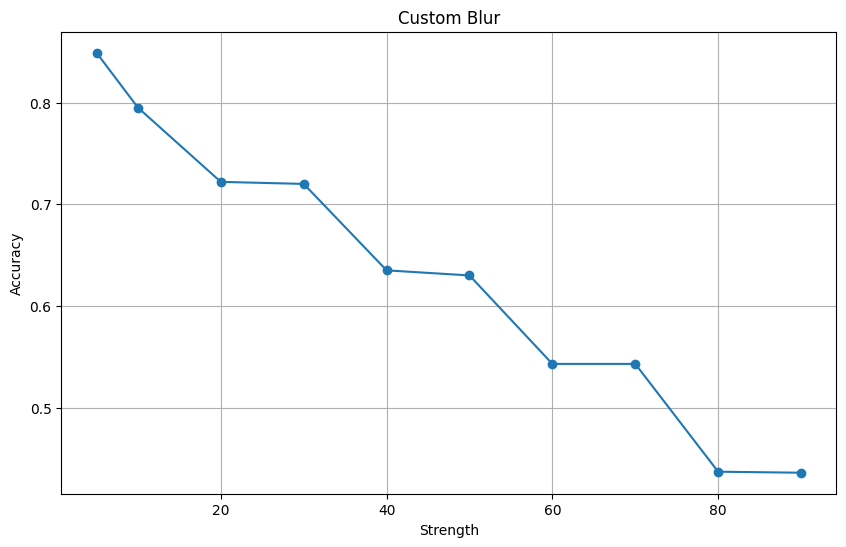

In [ ]:
strengths = list(custom_blur_results.keys())
accs = list(custom_blur_results.values())

plt.figure(figsize=(10,6))
plt.plot(strengths, accs, marker='o')
plt.title('Custom Blur')
plt.xlabel('Strength')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

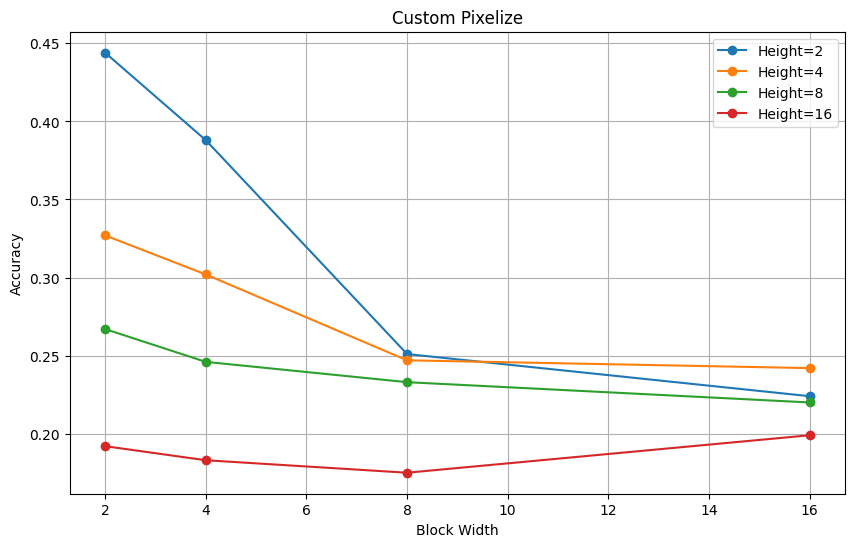

In [ ]:
df = pd.DataFrame(
    [(bh, bw, acc) for (bh, bw), acc in custom_pixelize_results.items()],
    columns=['Block Height', 'Block Width', 'Accuracy']
)

plt.figure(figsize=(10,6))
for bh in df['Block Height'].unique():
    subset = df[df['Block Height'] == bh]
    plt.plot(subset['Block Width'], subset['Accuracy'], marker='o', label=f'Height={bh}')

plt.title('Custom Pixelize')
plt.xlabel('Block Width')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


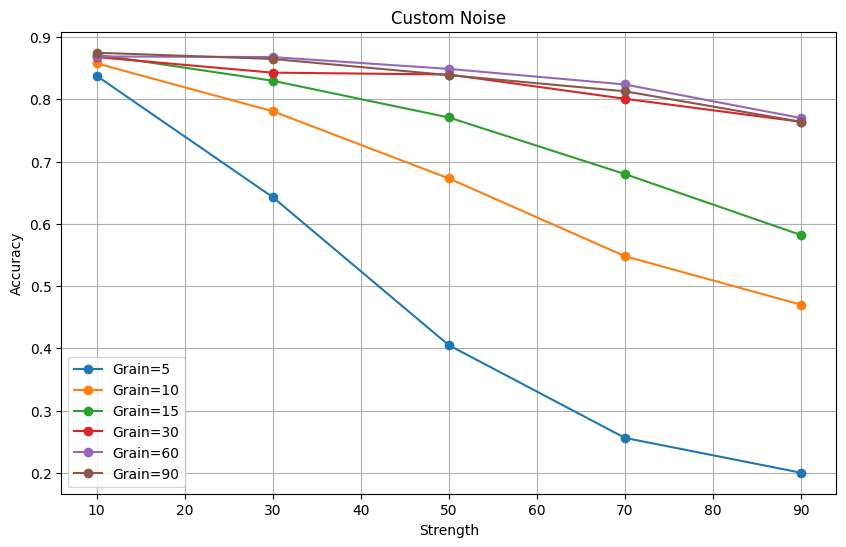

In [ ]:
df = pd.DataFrame(
    [(s, g, acc) for (s, g), acc in custom_noise_results.items()],
    columns=['Strength', 'Grain Size', 'Accuracy']
)

plt.figure(figsize=(10,6))
for g_size in df['Grain Size'].unique():
    subset = df[df['Grain Size'] == g_size]
    plt.plot(subset['Strength'], subset['Accuracy'], marker='o', label=f'Grain={g_size}')
plt.title('Custom Noise')
plt.xlabel('Strength')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

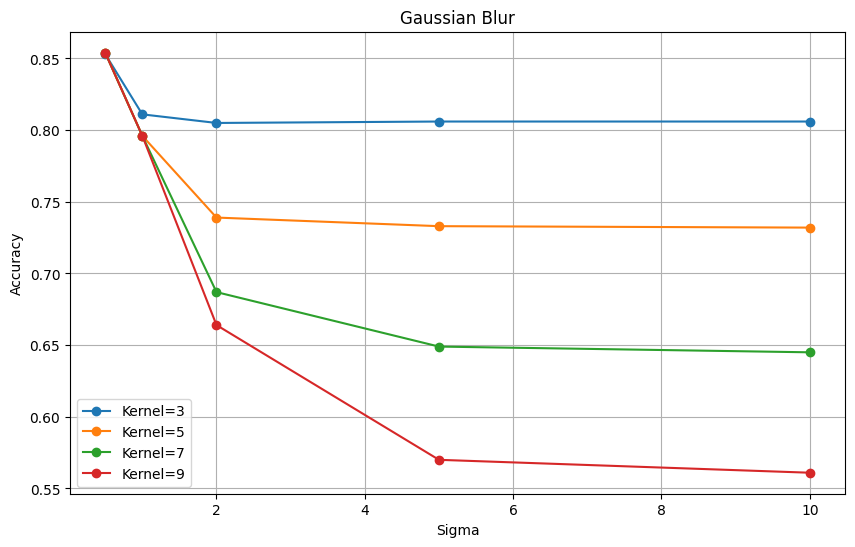

In [ ]:
df = pd.DataFrame(
    [(k, s, acc) for (k, s), acc in gaussian_blur_results.items()],
    columns=['Kernel Size', 'Sigma', 'Accuracy']
)

plt.figure(figsize=(10,6))
for k_size in df['Kernel Size'].unique():
    subset = df[df['Kernel Size'] == k_size]
    plt.plot(subset['Sigma'], subset['Accuracy'], marker='o', label=f'Kernel={k_size}')
plt.title('Gaussian Blur')
plt.xlabel('Sigma')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

1. **Custom Blur Evaluation:** As the blur strength increases, the images lose clarity
and fine details, making them progressively unrecognizable, which leads to a significant drop in the model's accuracy.

2. **Custom Pixelization Evaluation:**  Starting with small block sizes like 2x2, where multiple pixels are averaged into one, the model's accuracy is already small (~44%), and as the block sizes increase, the image loses even more granularity and recognizable details, leading to even lower accuracy.

3. **Custom Noise Evaluation:** For custom noise with low grain sizes, accuracy drops significantly as the noise strength increases, but for higher grain sizes, the drop in accuracy becomes less pronounced since the noise resembles larger patterns that may still preserve some structural information in the image.

4. **Gaussian Blur Evaluation:** In Gaussian blur, as the kernel size increases, the accuracy decreases for the same sigma values, since larger kernels apply more extensive blurring, further reducing image clarity.

In [ ]:
### END SOLUTION

#### 2b: Fine-tuning

Consider the following set of transformations: `{v2.Identity(), noise(strength=25, grain_size=3), v2.GaussianBlur(kernel_size=7, sigma=5)}`.

Compare how models fine-tuned for 3 epochs with each augmentation from that set<br>
(one at a time, using `Trainer(extra_augmentation=..., n_epochs=3)`, with `use_workers=False` if `noise` is used)<br>
performs on val with each augmentation from that set, and on the alt dataset with zero augmentations.<br>
We don't expect computations to take more than 20 minutes in total, for this subtask (on Colab GPU; CPU is too slow for fine-tuning, ~20min per epoch).

Present the `3 x 4` results in a table. Discuss the results in 1-2 sentences.

In [ ]:
### BEGIN SOLUTION

In [ ]:
augmentations = {
    "Identity": v2.Identity(),
    "Noise": v2.Lambda(lambda x: noise(x, strength=25, grain_size=3)),
    "GaussianBlur": v2.GaussianBlur(kernel_size=7, sigma=5)
}

results = {train_aug: {val_aug: 0 for val_aug in augmentations.keys()} for train_aug in augmentations.keys()}
alt_results = {train_aug: 0 for train_aug in augmentations.keys()}


for train_aug_name, train_aug in augmentations.items():
    print(f"Training with {train_aug_name} augmentation")
    trainer = Trainer(extra_augmentation=train_aug, n_epochs=3, use_workers=(train_aug_name != "Noise"))
    model = get_model(eval=True)

    trainer.train(model)

    for val_aug_name, val_aug in augmentations.items():
        print(f"Evaluating with {val_aug_name} augmentation")
        transform = v2.Compose([get_eval_transform(), val_aug])
        dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=transform)
        acc = evaluate(model, dataset, use_workers=(val_aug_name != "Noise"))
        results[train_aug_name][val_aug_name] = acc

    print("Evaluating with no augmentation")
    dataset = alt_test_dataset
    acc = evaluate(model, dataset, use_workers=(train_aug_name != "Noise"))
    alt_results[train_aug_name] = acc

Training with Identity augmentation
val=87.3 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:01<00:00,  1.28it/s, train-acc=82.2 %, lr=0.0002]


val=92.5 %	alt=49.6 %	


Train epoch   2: 100%|██████████| 79/79 [00:55<00:00,  1.41it/s, train-acc=87.5 %, lr=0.000194]


val=94.0 %	alt=51.1 %	


Train epoch   3: 100%|██████████| 79/79 [00:58<00:00,  1.36it/s, train-acc=88.8 %, lr=0.000188]


val=95.2 %	alt=50.6 %	
Evaluating with Identity augmentation


eval: 100%|██████████| 4/4 [00:08<00:00,  2.10s/it, accuracy=95.2 %]


Evaluating with Noise augmentation


eval: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it, accuracy=76.7 %]


Evaluating with GaussianBlur augmentation


eval: 100%|██████████| 4/4 [00:08<00:00,  2.19s/it, accuracy=78.7 %]


Evaluating with no augmentation


eval: 100%|██████████| 11/11 [00:12<00:00,  1.12s/it, accuracy=50.6 %]


Training with Noise augmentation
val=87.3 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:58<00:00,  1.50s/it, train-acc=74.4 %, lr=0.0002]


val=91.5 %	alt=50.1 %	


Train epoch   2: 100%|██████████| 79/79 [02:00<00:00,  1.53s/it, train-acc=81.4 %, lr=0.000194]


val=94.5 %	alt=52.4 %	


Train epoch   3: 100%|██████████| 79/79 [01:58<00:00,  1.50s/it, train-acc=83.3 %, lr=0.000188]


val=94.2 %	alt=52.1 %	
Evaluating with Identity augmentation


eval: 100%|██████████| 4/4 [00:08<00:00,  2.03s/it, accuracy=94.2 %]


Evaluating with Noise augmentation


eval: 100%|██████████| 4/4 [00:04<00:00,  1.13s/it, accuracy=86.1 %]


Evaluating with GaussianBlur augmentation


eval: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it, accuracy=79.5 %]


Evaluating with no augmentation


eval: 100%|██████████| 11/11 [00:08<00:00,  1.25it/s, accuracy=52.1 %]


Training with GaussianBlur augmentation
val=87.3 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:07<00:00,  1.18it/s, train-acc=75.0 %, lr=0.0002]


val=91.2 %	alt=51.9 %	


Train epoch   2: 100%|██████████| 79/79 [01:01<00:00,  1.28it/s, train-acc=82.2 %, lr=0.000194]


val=92.4 %	alt=53.4 %	


Train epoch   3: 100%|██████████| 79/79 [01:01<00:00,  1.29it/s, train-acc=84.0 %, lr=0.000188]


val=93.6 %	alt=53.5 %	
Evaluating with Identity augmentation


eval: 100%|██████████| 4/4 [00:07<00:00,  1.94s/it, accuracy=93.6 %]


Evaluating with Noise augmentation


eval: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it, accuracy=75.4 %]


Evaluating with GaussianBlur augmentation


eval: 100%|██████████| 4/4 [00:08<00:00,  2.13s/it, accuracy=84.8 %]


Evaluating with no augmentation


eval: 100%|██████████| 11/11 [00:12<00:00,  1.11s/it, accuracy=53.5 %]


In [ ]:
results_df = pd.DataFrame(results).transpose()
results_df['Alt'] = results_df.index.map(alt_results)

results_df = results_df.rename_axis("Train Augmentation").reset_index()

columns_order = ['Train Augmentation', 'Identity', 'Noise', 'GaussianBlur', 'Alt']
results_df = results_df[columns_order]

styled_df = results_df \
    .style.format(precision=3, thousands=".", decimal=",") \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center')]
    }]) \
    .hide(axis="index")

styled_df


Train Augmentation,Identity,Noise,GaussianBlur,Alt
Identity,"0,952","0,767","0,787","0,506"
Noise,"0,942","0,861","0,795","0,521"
GaussianBlur,"0,936","0,754","0,848","0,535"


Models fine-tuned with each specific augmentation achieve high accuracy on the Identity dataset and perform well on their corresponding augmented datasets, demonstrating effective adaptation to each transformation. The results could potentially improve with further fine-tuning over more epochs. However, accuracy remains low on the Alt dataset, indicating that it contains more complex or diverse augmentations that the models were not adequately fine-tuned to handle.

In [ ]:
### END SOLUTION

## Adversarial image modification with PGD

One method to improve robustness, other than augmentations, is to train on adversarial examples: images that are altered with small perturbations to fool the model.
Here's a typical implementation.

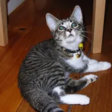

label=5 (cat)
Prediction: 5 (cat)


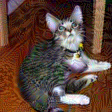

Prediction: 6 (chair)


In [ ]:
def adversarialPGD(
    model: torch.nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    epsilon: float = 4 / 255,
    alpha: float = 2 / 255,
    n_iters: int = 1,
    random_init: bool = False,
) -> torch.Tensor:
    """
    Find an input xᵃᵈᵛ within x±ε pushing `model(xᵃᵈᵛ)` away from y (maximizing loss, unless alpha is negative).

    Uses 'Projective Gradient Descent' with learning rate `alpha` and `n_iters` iterations, as introduced in:
    Madry et al., "Towards Deep Learning Models Resistant to Adversarial Attacks", ICRL 2018
    https://openreview.net/forum?id=rJzIBfZAb

    Assumes x is 0..1-valued and keeps it in these bounds (i.e., it expects unnormalized images).
    """
    was_training = model.training
    model.eval()
    x = x.clone().detach()
    with torch.no_grad():
        x_min = torch.clamp(x - epsilon, min=0)
        x_max = torch.clamp(x + epsilon, max=1)

        if random_init:
            x = x + torch.empty_like(x).uniform_(-epsilon, epsilon)
            x.clamp_(x_min, x_max)

    for _ in range(n_iters):
        x.requires_grad = True
        logits = model(x)
        loss = torch.nn.CrossEntropyLoss()(logits, y)
        with torch.no_grad():
            x_grad = torch.autograd.grad(loss, x)[0]
            # We could also:
            #   loss.backward()
            #   x_grad = x.grad.detach()
            # but then we'd nedd to temporarily set requires_grad=False on all model parameters.
            x = x.detach() + alpha * x_grad.sign()
            x.clamp_(x_min, x_max)
            x = x.detach()

    if was_training:
        model.train()
    return x.requires_grad_(False)


def example(device="cuda") -> None:
    model = get_model(eval=True).to(device)

    dataset = ImageFolder(MINI_IMAGENET_PATH / "val", transform=get_eval_transform())
    img, label = dataset[510]
    display_image_tensor(img)
    print(f"{label=} ({dataset.classes[label]})")

    img = img.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    pred = model(img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")

    adv_img = normalize(adversarialPGD(model, unnormalize(img), label, epsilon=20 / 255, n_iters=100))
    display_image_tensor(adv_img[0])
    pred = model(adv_img)[0].argmax().item()
    print(f"Prediction: {pred} ({dataset.classes[pred]})")


example()


## Task 3: AdvProp

Training on adversarial examples unfortunately tends to decrease accuracy on plain (unmodified) images a lot.<br>
The authors of [Adversarial Examples Improve Image Recognition](https://arxiv.org/abs/1911.09665) hypothesize that<br>
this is because adversarial examples (and the model activations they induce) follow different distributions.<br>
They propose addressing that by using auxilliary batch-norm-s for the adversarial images.

#### 3a: Implementation
Read the paper and implement this technique. Note that:
* Parameters (weights and biases of the affine transform applied after normalizing) should be the same for plain and adversarial images; only the running mean and variance (the buffers) are distinct.
* During evaluation, the plain batch-norms should be used.
* Add the two losses from plain and adversarial images using weights that sum up to one, specifically: `0.75 * plain_loss + 0.25 * adversarial_loss`.
* You should not need to alter this and other hyperparameters; use the defaults of `Trainer.__init__()` and `adversarialPGD` (they are different than suggested in the paper, but work better in our case).
* See `get_model()` for an example of how layers can be replaced. You can assume all batch-norms are instances of `torch.nn.BatchNorm2d` (with `affine=True`, `track_running_stats=True`, and non-null `momentum`).

In [ ]:
### BEGIN SOLUTION

class DualBatchNorm2d(torch.nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()

        self.adv = False

        self.clean_bn = torch.nn.BatchNorm2d(
            num_features, eps=eps, momentum=momentum, affine=affine, track_running_stats=track_running_stats
        )

        self.adv_bn = torch.nn.BatchNorm2d(
            num_features, eps=eps, momentum=momentum, affine=affine, track_running_stats=track_running_stats
        )

        if affine:
            self.adv_bn.weight = self.clean_bn.weight
            self.adv_bn.bias = self.clean_bn.bias

    def forward(self, x):
        if not self.training or not self.adv:
            return self.clean_bn(x)
        else:
            return self.adv_bn(x)


def replace_bn_with_dualbn(model, momentum=0.002):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.BatchNorm2d):
            dual_bn = DualBatchNorm2d(
                module.num_features,
                eps=module.eps,
                momentum=momentum,
                affine=module.affine,
                track_running_stats=module.track_running_stats
            )

            if module.affine:
                with torch.no_grad():
                    dual_bn.clean_bn.weight.data.copy_(module.weight.data)
                    dual_bn.clean_bn.bias.data.copy_(module.bias.data)

            if module.track_running_stats:
                with torch.no_grad():
                    dual_bn.clean_bn.running_mean.data.copy_(module.running_mean.data)
                    dual_bn.clean_bn.running_var.data.copy_(module.running_var.data)
                    dual_bn.adv_bn.running_mean.data.copy_(module.running_mean.data)
                    dual_bn.adv_bn.running_var.data.copy_(module.running_var.data)

            setattr(model, name, dual_bn)
        else:
            replace_bn_with_dualbn(module, momentum)

    return model

### END SOLUTION

In [ ]:
class AdvPropTrainer(Trainer):
    def __init__(
        self,
        lr: float = 2e-4,
        weight_decay: float = 3e-5,
        batch_norm_momentum: float | None = 0.002,
        n_epochs: int = 10,
        device: str = "cuda",
        n_iters: int = 1,
        epsilon: float = 4 / 255,
        alpha: float = 2 / 255,
        adv_ratio: float = 0.25,
    ):
        super().__init__(
            lr=lr, weight_decay=weight_decay, batch_norm_momentum=batch_norm_momentum, n_epochs=n_epochs, device=device
        )
        self.n_iters = n_iters
        self.epsilon = epsilon
        self.alpha = alpha
        self.adv_ratio = adv_ratio

    ### BEGIN SOLUTION

    def train(self, model: torch.nn.Module) -> dict[str, list[float]]:
        model = replace_bn_with_dualbn(model, momentum=self.batch_norm_momentum).to(self.device)
        return super().train(model)

    def train_epoch(
        self, model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer, epoch: int
    ) -> None:
        model.train()

        correct_clean = 0
        correct_adv = 0
        total_samples = 0

        progress_bar = tqdm(dataloader, desc=f"Train epoch {epoch:>3}")
        ce_loss = torch.nn.CrossEntropyLoss()

        for image_batch, label_batch in progress_bar:
            image_batch, label_batch = image_batch.to(self.device), label_batch.to(self.device)

            x_adv = adversarialPGD(
                model, image_batch, label_batch, epsilon=self.epsilon, alpha=self.alpha, n_iters=self.n_iters
            )

            for module in model.modules():
                if isinstance(module, DualBatchNorm2d):
                    module.adv = True

            logits_adv = model(x_adv)
            loss_adv = ce_loss(logits_adv, label_batch)

            for module in model.modules():
                if isinstance(module, DualBatchNorm2d):
                    module.adv = False

            logits_clean = model(image_batch)
            loss_clean = ce_loss(logits_clean, label_batch)

            loss = (1 - self.adv_ratio) * loss_clean + self.adv_ratio * loss_adv

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                correct_clean += (logits_clean.argmax(dim=1) == label_batch).sum().item()
                correct_adv += (logits_adv.argmax(dim=1) == label_batch).sum().item()
                total_samples += len(label_batch)

            clean_accuracy = correct_clean / total_samples
            adv_accuracy = correct_adv / total_samples
            progress_bar.set_postfix({
                "clean-acc": f"{clean_accuracy * 100:.1f}%",
                "adv-acc": f"{adv_accuracy * 100:.1f}%",
                "lr": optimizer.param_groups[0]["lr"]
            })


    ### END SOLUTION

#### 3b: Evaluation

Compare Trainer and AdvPropTrainer (using default hyperparameters, 10 epochs, in particular).<br>
(One training with Trainer / AdvPropTrainer takes roughly 15 / 20 minutes on colab GPU, respectively).<br>
Discuss the results in 1-3 sentences (consider proposing what could be tested further, with more time).

In [ ]:
### BEGIN SOLUTION

In [ ]:
model = get_model()
trainer = Trainer()
results_trainer = trainer.train(model)

val=87.2 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:27<00:00,  1.10s/it, train-acc=65.7 %, lr=0.0002]


val=88.6 %	alt=52.0 %	


Train epoch   2: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, train-acc=77.0 %, lr=0.000194]


val=91.7 %	alt=52.6 %	


Train epoch   3: 100%|██████████| 79/79 [01:29<00:00,  1.13s/it, train-acc=79.6 %, lr=0.000188]


val=91.6 %	alt=54.8 %	


Train epoch   4: 100%|██████████| 79/79 [01:28<00:00,  1.12s/it, train-acc=80.0 %, lr=0.000183]


val=92.7 %	alt=54.9 %	


Train epoch   5: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, train-acc=81.7 %, lr=0.000177]


val=93.3 %	alt=52.1 %	


Train epoch   6: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, train-acc=82.3 %, lr=0.000172]


val=93.7 %	alt=53.0 %	


Train epoch   7: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=83.0 %, lr=0.000167]


val=93.8 %	alt=52.4 %	


Train epoch   8: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, train-acc=83.6 %, lr=0.000162]


val=93.9 %	alt=53.6 %	


Train epoch   9: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=83.8 %, lr=0.000157]


val=93.6 %	alt=53.5 %	


Train epoch  10: 100%|██████████| 79/79 [01:21<00:00,  1.04s/it, train-acc=84.7 %, lr=0.000152]


val=93.8 %	alt=52.8 %	


In [ ]:
adv_model = get_model()
adv_trainer = AdvPropTrainer()
results_adv_trainer = adv_trainer.train(adv_model)

val=87.3 %	alt=43.4 %	


Train epoch   1: 100%|██████████| 79/79 [01:29<00:00,  1.14s/it, clean-acc=66.1%, adv-acc=56.5%, lr=0.0002]


val=88.5 %	alt=54.0 %	


Train epoch   2: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, clean-acc=76.9%, adv-acc=66.5%, lr=0.000194]


val=90.3 %	alt=54.6 %	


Train epoch   3: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, clean-acc=79.7%, adv-acc=68.4%, lr=0.000188]


val=91.4 %	alt=54.4 %	


Train epoch   4: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, clean-acc=81.2%, adv-acc=69.5%, lr=0.000183]


val=93.2 %	alt=55.6 %	


Train epoch   5: 100%|██████████| 79/79 [01:25<00:00,  1.09s/it, clean-acc=81.5%, adv-acc=68.4%, lr=0.000177]


val=93.3 %	alt=56.3 %	


Train epoch   6: 100%|██████████| 79/79 [01:22<00:00,  1.05s/it, clean-acc=82.5%, adv-acc=69.3%, lr=0.000172]


val=92.9 %	alt=55.9 %	


Train epoch   7: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, clean-acc=83.0%, adv-acc=69.2%, lr=0.000167]


val=93.6 %	alt=56.2 %	


Train epoch   8: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, clean-acc=83.5%, adv-acc=69.2%, lr=0.000162]


val=94.6 %	alt=55.1 %	


Train epoch   9: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, clean-acc=83.6%, adv-acc=69.2%, lr=0.000157]


val=94.8 %	alt=55.7 %	


Train epoch  10: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, clean-acc=84.0%, adv-acc=70.6%, lr=0.000152]


val=94.3 %	alt=55.3 %	


AdvPropTrainer achieves higher accuracy on both the validation set and the alt dataset, consistent with the paper. The improvement on the alt dataset is more pronounced because AdvPropTrainer calculates the loss using both clean and adversarially perturbed images. This dual loss computation allows the model to better generalize and maintain robustness against adversarial perturbations, resulting in enhanced performance on datasets that include such variations.

Future work could include testing the model against a variety of adversarial attack types and experimenting with different hyperparameter settings.

In [ ]:
### END SOLUTION

## Task 4: SparseTopK

Another technique to improve robustness against style and pattern changes was proposed in
[Emergence of Shape Bias in CNNs through Activation Sparsity](https://openreview.net/forum?id=QzcZb3fWmW)
(you do not need to read the paper).
The idea is simple: in between some layers, enforce activation sparsity by zeroing out all but the top say 20% activations (by absolute value).
The hope is that the strong activations, which we keep, encode the more generalizable shape information.

More formally `SparseTopK`, for a fixed fraction $k$ like $20\%$, should be a module that for an input $x \in \mathbb{R}^{C \times H \times W}$ outputs:
$$ \begin{align*}
    x_{\text{out}}[c,h,w] &= x[c,h,w]\quad &&\text{ if } |x[c,h,w]| \geq \text{top-k-percentile}(x[c,:,:]) \\
                          &= 0 \quad &&\text{ otherwise}
\end{align*} $$

Your task is to:
* implement such a module below (for inputs of shape `(batch_size, C, H, W)`),
* run the example once (for 10 epochs),
* shortly discuss the result (one sentence).

In [ ]:
class SparseTopK(torch.nn.Module):
    def __init__(self, k: float):
        super().__init__()
        self.k = k
        assert 0 <= k <= 1, f"Expected 0 ≤ k ≤ 1, got {k}."

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### BEGIN SOLUTION

        B, C, H, W = x.shape

        flat = x.abs().view(B, C, -1)

        if self.k < 1.0:
            thresholds = torch.quantile(flat, 1 - self.k, dim=-1, keepdim=True)
        else:
            thresholds = torch.full((B, C, 1), -float('inf'), device=x.device, dtype=x.dtype)

        thresholds = thresholds.expand(B, C, H*W).view(B, C, H, W)

        mask = (x.abs() >= thresholds)
        x = x * mask

        ### END SOLUTION
        return x


def example_sparse() -> None:
    model = get_model()
    # The paper tests on ResNet18 and suggests inserting one SparseTopK(0.2) module after the second layer.
    # We'll do something similar for our model, EfficientNetB0.
    model.features[1][0].block.insert(3, SparseTopK(0.2))

    Trainer().train(model)


example_sparse()

val=71.8 %	alt=32.1 %	


Train epoch   1: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it, train-acc=53.6 %, lr=0.0002]


val=82.1 %	alt=53.8 %	


Train epoch   2: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=66.8 %, lr=0.000194]


val=83.9 %	alt=52.8 %	


Train epoch   3: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=70.5 %, lr=0.000188]


val=86.7 %	alt=54.4 %	


Train epoch   4: 100%|██████████| 79/79 [01:18<00:00,  1.01it/s, train-acc=72.3 %, lr=0.000183]


val=88.0 %	alt=54.1 %	


Train epoch   5: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=74.3 %, lr=0.000177]


val=88.5 %	alt=54.5 %	


Train epoch   6: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, train-acc=74.5 %, lr=0.000172]


val=89.3 %	alt=53.0 %	


Train epoch   7: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=75.6 %, lr=0.000167]


val=90.1 %	alt=53.1 %	


Train epoch   8: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=76.5 %, lr=0.000162]


val=90.7 %	alt=52.5 %	


Train epoch   9: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, train-acc=77.3 %, lr=0.000157]


val=91.0 %	alt=52.8 %	


Train epoch  10: 100%|██████████| 79/79 [01:20<00:00,  1.02s/it, train-acc=77.4 %, lr=0.000152]


val=91.1 %	alt=54.2 %	


`### BEGIN SOLUTION (discussion)`

It led to a decrease in validation accuracy to 91.1%, while increasing accuracy on the alt dataset to 54.2% (compared to the get_model() run in ex. 3b). The decrease in validation accuracy resulted from the model discarding some activations that are "useful". However, the improvement on the alt dataset suggests that enforcing activation sparsity helps the model focus on more generalizable shape information.

`### END SOLUTION`